In [32]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
import meep as mp

mp.verbosity(0);

Simulate 2D top view where z-direction (vertical to chip) is collapsed. Use effective index instead.

In [33]:
wavelength = 1.31  # Wavelength in µm
n_Si = 2.99463     # TE-like effective index 2.99463 (1.31 µm) | 2.84813 (1.55 µm)
# n_Si = 2.40246     # TM-like effective index 2.40246  (1.31 µm) | 2.05368 (1.55 µm) 
n_SiO2 = 1.44672   # 1.44672 (1.31 µm) | 1.44400 (1.55 µm)
h_Si = 0.22        # Thickness in µm
w_Si = 0.41        # Width in µm
d_pml = 1.0        # PML thickness in µm
resolution = 50    # pixels/µm
fcen = 1/wavelength

In [34]:
## Geometry
geometry = [mp.Block(mp.Vector3(mp.inf, w_Si, h_Si),
                     center = mp.Vector3(),
                     material = mp.Medium(index=n_Si))]
## Simulation Domain
lx = int(1*wavelength*10)/10
ly = int(4*w_Si*10)/10
sx = lx + 2*d_pml
sy = ly + 2*d_pml 

## Light Source
sources = [mp.EigenModeSource(mp.GaussianSource(frequency=fcen, fwidth=0.1*fcen),
                              center = mp.Vector3(-lx/2, 0),
                              size = mp.Vector3(0, ly),
                              eig_band = 1,  # Integer or DiffractedPlaneWave class, default 1, index of the desired band where 1 denotes the lowest-frequency band at a given k point
                              # eig_parity = mp.ODD_Y+mp.EVEN_Z)]  # TE-like mode (Hz,Ey,Ex,...)
                              # eig_parity = mp.EVEN_Y+mp.ODD_Z)]  # TM-like mode (Ez,Hy,Hx,...); 
                              direction = mp.NO_DIRECTION,
                              eig_kpoint = mp.Vector3(1,0,0))]
## Simulation Object
sim = mp.Simulation(geometry = geometry,
                    cell_size = mp.Vector3(sx, sy),
                    boundary_layers =  [mp.PML(d_pml)],
                    sources = sources,
                    resolution = resolution,
                    default_material = mp.Medium(index=n_SiO2))
## Monitors
monitor = sim.add_dft_fields([mp.Hz, mp.Ey, mp.Ex], fcen, 0, 1,  # TE-like mode
                             # [mp.Ez, mp.Hy, mp.Hx], fcen, 0, 1,  # TM-like mode
                             center = mp.Vector3(0, 0),
                             size = mp.Vector3(lx, ly))

FDTD solve with DFT (Discrete Fourier Transform) monitor

有限差分時域法 FDTD (Finite-Difference Time Domain)：求解電磁場在各個位置、各個時刻的數值  
經過時域 Fourier Transform，可以得到頻域的 Response

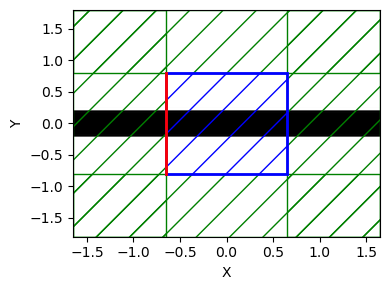

In [35]:
fig, ax = plt.subplots(figsize=(4,3))
sim.plot2D(ax=ax)
ax.axis('auto')
fig.tight_layout()

In [28]:
## stop_when_fields_decayed(dt, component, location, decay_by)
## keep incrementing runtime by dt
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ey, mp.Vector3(0,0), 1e-9))  # TE-like mode
# sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, mp.Vector3(0,0), 1e-9))  # TM-like mode

In [30]:
field = sim.get_dft_array(monitor, mp.Ey, 0)  # TE-like mode
# field = sim.get_dft_array(monitor, mp.Ez, 0)  # TM-like mode
[x, y, z, w] = sim.get_array_metadata(dft_cell=monitor)

print(field.shape)
print(x.shape)
print(y.shape)

(66, 82)
(66,)
(82,)


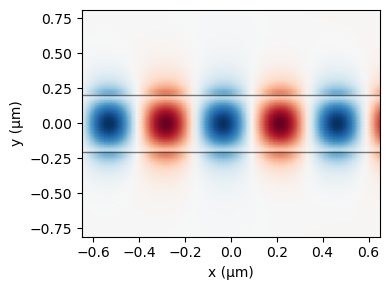

In [31]:
fig, ax = plt.subplots(figsize=(4,3))
ax.axhline(w_Si/2, c='k', lw=1, alpha=0.5)
ax.axhline(-w_Si/2, c='k', lw=1, alpha=0.5)
ax.pcolormesh(x, y, np.rot90(np.real(field)), cmap="RdBu", shading="gouraud")
ax.set(xlabel="x (µm)", ylabel="y (µm)")
fig.tight_layout()